In [1]:
import numpy as np
import matplotlib.pyplot as plt

4.5 計算例

4.5.1 衝撃波管問題 \
使用スキーム：HLLD法・WENO・ホイン法 or 中点法 

In [27]:
def minmod(x, y):
    return np.sign(x) * np.maximum(np.minimum(np.abs(x), np.sign(x) * y), 1e-10)


def WENO(q, axis):
    epsilon = 1e-6
    q0 = (2.0 * np.roll(q, 2, axis=axis) - 7.0 * np.roll(q, 1, axis=axis) + 11.0 * q) / 6.0
    q1 = (-np.roll(q, 1, axis=axis) + 5.0 * q + 2.0 * np.roll(q, -1, axis=axis)) / 6.0 
    q2 = (2.0 * q + 5.0 * np.roll(q, -1, axis=axis) - np.roll(q, -2, axis=axis)) / 6.0
    IS0 = 13.0/12.0 * (np.roll(q, 2, axis=axis) - 2.0 * np.roll(q, 1, axis=axis) + q)**2 \
        + 1.0/4.0 * (np.roll(q, 2, axis=axis) - 4.0 * np.roll(q, 1, axis=axis) + 3.0 * q)**2
    IS1 = 13.0/12.0 * (np.roll(q, 1, axis=axis) - 2.0 * q + np.roll(q, -1, axis=axis))**2 \
        + 1.0/4.0 * (np.roll(q, 1, axis=axis) - np.roll(q, -1, axis=axis))**2
    IS2 = 13.0/12.0 * (q - 2.0 * np.roll(q, -1, axis=axis) + np.roll(q, -2, axis=axis))**2 \
        + 1.0/4.0 * (3.0 * q - 4.0 * np.roll(q, -1, axis=axis) + np.roll(q, -2, axis=axis))**2
    a0 = 0.1 / (IS0 + epsilon)**2
    a1 = 0.6 / (IS1 + epsilon)**2
    a2 = 0.3 / (IS2 + epsilon)**2
    w0 = a0 / (a0 + a1 + a2)
    w1 = a1 / (a0 + a1 + a2)
    w2 = a2 / (a0 + a1 + a2)
    q_L = w0 * q0 + w1 * q1 + w2 * q2

    return q_L


def get_LR_component(rho, u, v, w, By, Bz, p, axis):
    rho_L = WENO(rho, axis)
    u_L = WENO(u, axis)
    v_L = WENO(v, axis)
    w_L = WENO(w, axis)
    By_L = WENO(By, axis)
    Bz_L = WENO(Bz, axis)
    p_L = WENO(p, axis)
    rho_R = np.roll(rho_L, -1, axis=axis)
    u_R = np.roll(u_L, -1, axis=axis)
    v_R = np.roll(v_L, -1, axis=axis)
    w_R = np.roll(w_L, -1, axis=axis)
    By_R = np.roll(By_L, -1, axis=axis)
    Bz_R = np.roll(Bz_L, -1, axis=axis)
    p_R = np.roll(p_L, -1, axis=axis)

    return rho_L, rho_R, u_L, u_R, v_L, v_R, w_L, w_R, By_L, By_R, Bz_L, Bz_R, p_L, p_R


def get_U_parameters_1(rho, u, v, w, Bx, By, Bz, e, pT, pT1, S, SM):
    rho1 = rho * (S - u) / (S - SM + 1e-20)
    u1 = SM
    v1 = v - Bx * By * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2 + 1e-20)
    w1 = w - Bx * Bz * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2 + 1e-20)
    By1 = By * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2 + 1e-20)
    Bz1 = Bz * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2 + 1e-20)
    e1 = ((S - u) * e - pT * u + pT1 * SM + Bx * ((u*Bx + v*By + w*Bz) - (u1*Bx + v1*By1 + w1*Bz1))) / (S - SM + 1e-20)
    
    return rho1, u1, v1, w1, By1, Bz1, e1


def get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM):
    u2 = SM
    v2 = (np.sqrt(rho1_L) * v1_L + np.sqrt(rho1_R) * v1_R + (By1_R - By1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    w2 = (np.sqrt(rho1_L) * w1_L + np.sqrt(rho1_R) * w1_R + (Bz1_R - Bz1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    By2 = (np.sqrt(rho1_L) * By1_R + np.sqrt(rho1_R) * By1_L + np.sqrt(rho1_L * rho1_R) * (v1_R - v1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    Bz2 = (np.sqrt(rho1_L) * Bz1_R + np.sqrt(rho1_R) * Bz1_L + np.sqrt(rho1_L * rho1_R) * (w1_R - w1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    e2_L = e1_L - np.sqrt(rho1_L) * ((u1_L * Bx + v1_L * By1_L + w1_L * Bz1_L) - (u2 * Bx + v2 * By2 + w2 * Bz2)) * np.sign(Bx)
    e2_R = e1_R + np.sqrt(rho1_R) * ((u1_R * Bx + v1_R * By1_R + w1_R * Bz1_R) - (u2 * Bx + v2 * By2 + w2 * Bz2)) * np.sign(Bx)

    return u2, v2, w2, By2, Bz2, e2_L, e2_R


def get_flux(rho, u, v, w, Bx, By, Bz, e, pT, F):
    F[0, :] = rho * u
    F[1, :] = rho * u**2 + pT - Bx**2
    F[2, :] = rho * u * v - Bx * By
    F[3, :] = rho * u * w - Bx * Bz
    F[4, :] = 0.0
    F[5, :] = u * By - v * Bx
    F[6, :] = u * Bz - w * Bx
    F[7, :] = (e + pT) * u - Bx * (Bx * u + By * v + Bz * w)
    return F


def get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis):

    p = (gamma - 1.0) * (e - rho * (u**2 + v**2 + w**2) / 2.0 - (Bx**2 + By**2 + Bz**2) / 2.0)
    # eではなくp(ガス圧)を補間。これで流速が大きいときでも対応できた
    rho_L, rho_R, u_L, u_R, v_L, v_R, w_L, w_R, By_L, By_R, Bz_L, Bz_R, p_L, p_R = get_LR_component(rho, u, v, w, By, Bz, p, axis)
    pT_L = p_L + (Bx**2 + By_L**2 + Bz_L**2) / 2.0
    pT_R = p_R + (Bx**2 + By_R**2 + Bz_R**2) / 2.0
    e_L = p_L / (gamma - 1) + rho_L * (u_L**2 + v_L**2 + w_L**2) / 2.0 + (Bx**2 + By_L**2 + Bz_L**2) / 2.0
    e_R = p_R / (gamma - 1) + rho_R * (u_R**2 + v_R**2 + w_R**2) / 2.0 + (Bx**2 + By_R**2 + Bz_R**2) / 2.0
    cs_L = np.sqrt(gamma * p_L / rho_L)
    cs_R = np.sqrt(gamma * p_R / rho_R)
    ca_L = np.sqrt((Bx**2 + By_L**2 + Bz_L**2) / rho_L)
    ca_R = np.sqrt((Bx**2 + By_R**2 + Bz_R**2) / rho_R)
    va_L = np.abs(Bx) / np.sqrt(rho_L)
    va_R = np.abs(Bx) / np.sqrt(rho_R)
    cf_L = np.sqrt((cs_L**2 + ca_L**2 + np.sqrt((cs_L**2 + ca_L**2)**2 - 4.0 * cs_L**2 * va_L**2)) / 2)
    cf_R = np.sqrt((cs_R**2 + ca_R**2 + np.sqrt((cs_R**2 + ca_R**2)**2 - 4.0 * cs_R**2 * va_R**2)) / 2)

    S_L = np.minimum(u_L, u_R) - np.maximum(cf_L, cf_R)
    S_R = np.maximum(u_L, u_R) + np.maximum(cf_L, cf_R)
    S_L = np.minimum(S_L, 0.0)
    S_R = np.maximum(S_R, 0.0)

    SM = ((S_R - u_R) * rho_R * u_R - (S_L - u_L) * rho_L * u_L - pT_R + pT_L) / ((S_R - u_R) * rho_R - (S_L - u_L) * rho_L)
    pT1 = ((S_R - u_R) * rho_R * pT_L - (S_L - u_L) * rho_L * pT_R + rho_L * rho_R * (S_R - u_R) * (S_L - u_L) * (u_R - u_L)) / ((S_R - u_R) * rho_R - (S_L - u_L) * rho_L)
    pT1_L = pT1
    pT1_R = pT1
    rho1_L, u1_L, v1_L, w1_L, By1_L, Bz1_L, e1_L = get_U_parameters_1(rho_L, u_L, v_L, w_L, Bx, By_L, Bz_L, e_L, pT_L, pT1_L, S_L, SM)
    rho1_R, u1_R, v1_R, w1_R, By1_R, Bz1_R, e1_R = get_U_parameters_1(rho_R, u_R, v_R, w_R, Bx, By_R, Bz_R, e_R, pT_R, pT1_R, S_R, SM)

    S1_L = SM - np.abs(Bx)/np.sqrt(rho1_L)
    S1_R = SM + np.abs(Bx)/np.sqrt(rho1_R)

    u2, v2, w2, By2, Bz2, e2_L, e2_R = get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM)
    pT2_L = pT1
    pT2_R = pT1
    rho2_L = rho1_L
    rho2_R = rho1_R

    # Fの選択
    F_L = np.zeros(F.shape)
    F1_L = np.zeros(F.shape)
    F2_L = np.zeros(F.shape)
    F_R = np.zeros(F.shape)
    F1_R = np.zeros(F.shape)
    F2_R = np.zeros(F.shape)
    F_L = get_flux(rho_L, u_L, v_L, w_L, Bx, By_L, Bz_L, e_L, pT_L, F_L)
    F1_L = get_flux(rho1_L, u1_L, v1_L, w1_L, Bx, By1_L, Bz1_L, e1_L, pT1_L, F1_L)
    F2_L = get_flux(rho2_L, u2, v2, w2, Bx, By2, Bz2, e2_L, pT2_L, F2_L)
    F_R = get_flux(rho_R, u_R, v_R, w_R, Bx, By_R, Bz_R, e_R, pT_R, F_R)
    F1_R = get_flux(rho1_R, u1_R, v1_R, w1_R, Bx, By1_R, Bz1_R, e1_R, pT1_R, F1_R)
    F2_R = get_flux(rho2_R, u2, v2, w2, Bx, By2, Bz2, e2_R, pT2_R, F2_R)

    F = F_L * (S_L > 0.0) + F1_L * ((S_L <= 0.0) & (0.0 < S1_L)) + F2_L * ((S1_L <= 0.0) & (0.0 < SM)) \
      + F_R * (S_R <= 0.0) + F1_R * ((S1_R <= 0.0) & (0.0 < S_R)) + F2_R * ((SM <= 0.0) & (0.0 < S1_R))

    return F

In [28]:
dx = 0.001
dt = 0.0002
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.125
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([0.75, 1.0, 0.0])
B_R_init = np.array([0.75, -1.0, 0.0])
p_L_init = 1.0
p_R_init = 0.1
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * np.linalg.norm(velocity_L_init)**2/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

In [29]:
max_step = 10000
time = 0.0
calculation_time = 0.2
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break

1108 steps (t = 0.200) : Calculation is stopped


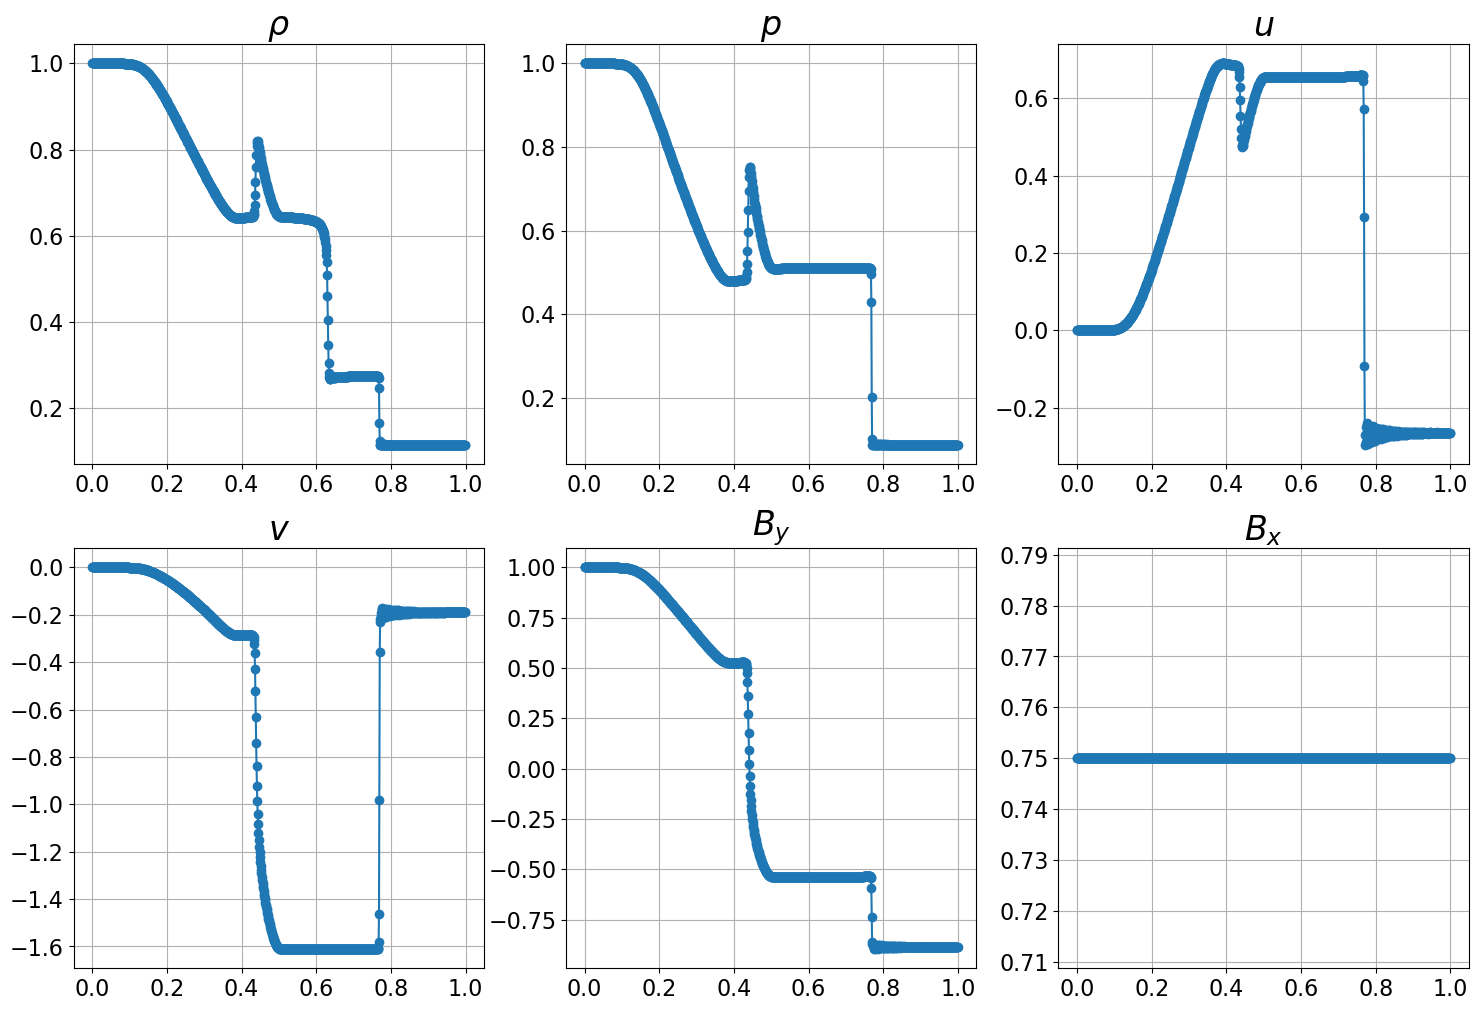

In [30]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bx, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_x$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

y方向バージョンによるテスト(フラックスG)

In [6]:
dy = 0.001
dt = 0.0002
y_max = 1.0
y = np.arange(0.0, y_max, dy)
nmax = len(y)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, y.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.125
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([0.0, 0.75, 1.0])
B_R_init = np.array([0.0, 0.75, -1.0])
p_L_init = 1.0
p_R_init = 0.1
U[0, y < y_max/2] = rho_L_init
U[0, y >= y_max/2] = rho_R_init
U[1, y < y_max/2] = rho_L_init * velocity_L_init[0]
U[1, y >= y_max/2] = rho_R_init * velocity_R_init[0]
U[2, y < y_max/2] = rho_L_init * velocity_L_init[1]
U[2, y >= y_max/2] = rho_R_init * velocity_R_init[1]
U[3, y < y_max/2] = rho_L_init * velocity_L_init[2]
U[3, y >= y_max/2] = rho_R_init * velocity_R_init[2]
U[4, y < y_max/2] = B_L_init[0]
U[4, y >= y_max/2] = B_R_init[0]
U[5, y < y_max/2] = B_L_init[1]
U[5, y >= y_max/2] = B_R_init[1]
U[6, y < y_max/2] = B_L_init[2]
U[6, y >= y_max/2] = B_R_init[2]
U[7, y < y_max/2] = p_L_init/(gamma-1) + rho_L_init * np.linalg.norm(velocity_L_init)**2/2 + np.linalg.norm(B_L_init)**2/2
U[7, y >= y_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

G = np.zeros(U.shape)
G_bar = np.zeros(G.shape)

In [7]:
max_step = 10000
time = 0.0
calculation_time = 0.2
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    G = get_flux_HLLD(rho, v, w, u, By, Bz, Bx, e, gamma, G, axis=0)
    G_tmp = G.copy()
    G[1, :] = G_tmp[3, :]
    G[2, :] = G_tmp[1, :]
    G[3, :] = G_tmp[2, :]
    G[4, :] = G_tmp[6, :]
    G[5, :] = G_tmp[4, :]
    G[6, :] = G_tmp[5, :]

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dy))
    
    U_bar += -dt/dy * (G - np.roll(G, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    G_bar = get_flux_HLLD(rho, v, w, u, By, Bz, Bx, e, gamma, G_bar, axis=0)
    G_tmp = G_bar.copy()
    G_bar[1, :] = G_tmp[3, :]
    G_bar[2, :] = G_tmp[1, :]
    G_bar[3, :] = G_tmp[2, :]
    G_bar[4, :] = G_tmp[6, :]
    G_bar[5, :] = G_tmp[4, :]
    G_bar[6, :] = G_tmp[5, :]
    G = 1/2 * (G + G_bar)

    U += -dt/dy * (G - np.roll(G, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break

1053 steps (t = 0.200) : Calculation is stopped


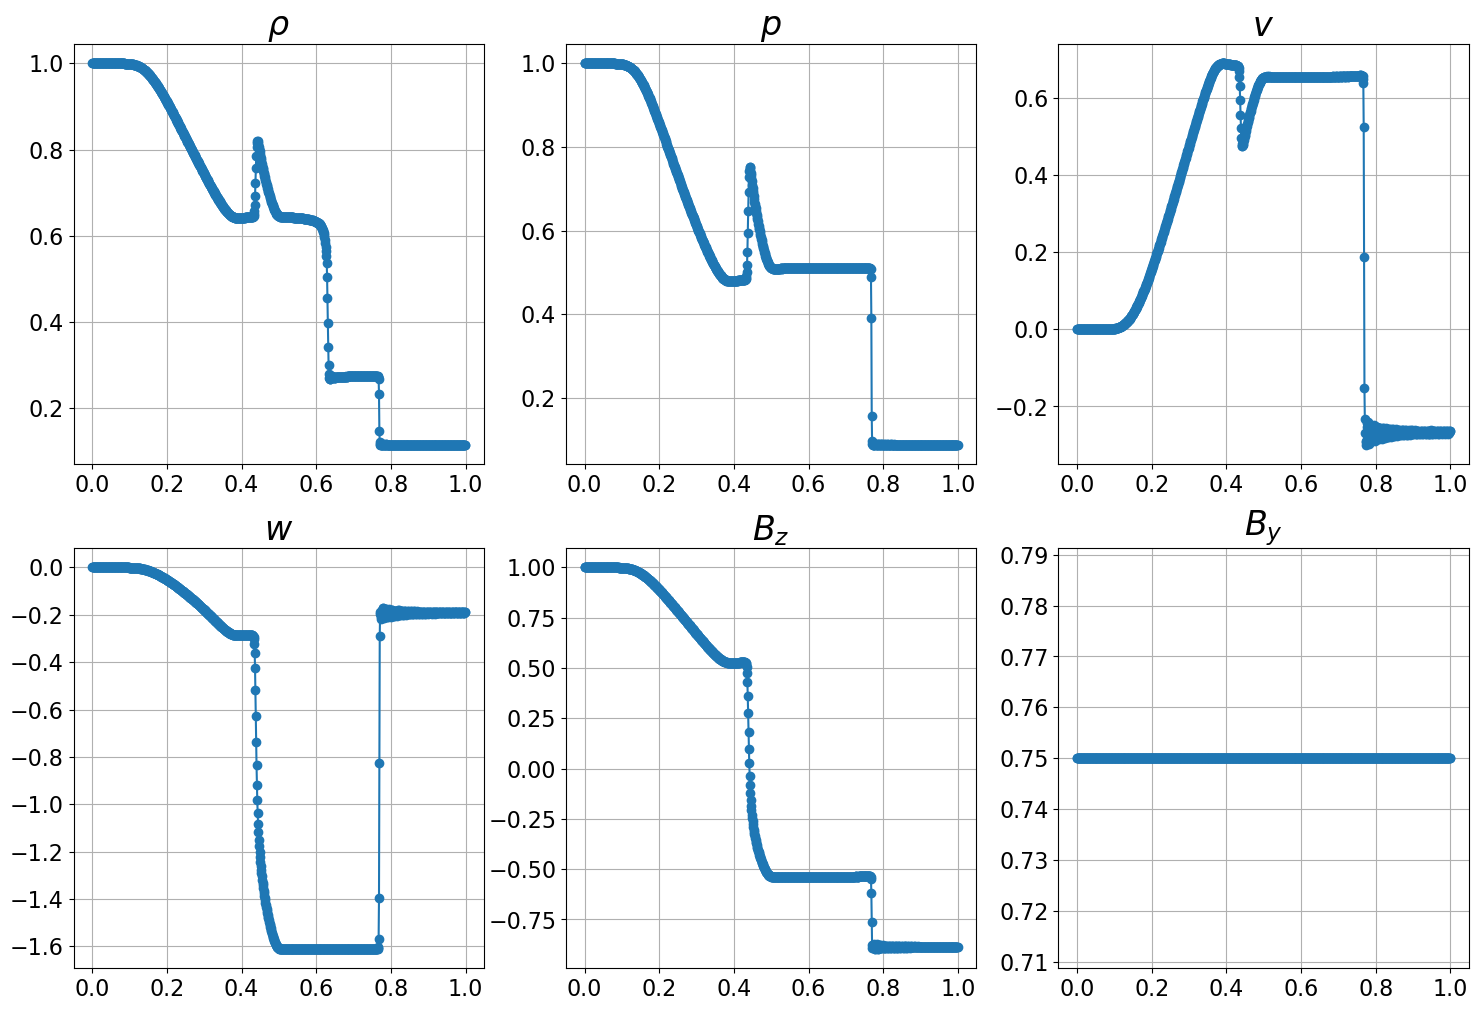

In [8]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(y, rho, marker='o')
ax2.plot(y, p, marker='o')
ax3.plot(y, v, marker='o')
ax4.plot(y, w, marker='o')
ax5.plot(y, Bz, marker='o')
ax6.plot(y, By, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$v$", fontsize=24)
ax4.set_title(r"$w$", fontsize=24)
ax5.set_title(r"$B_z$", fontsize=24)
ax6.set_title(r"$B_y$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

z方向バージョンによるテスト(フラックスH)

In [9]:
dz = 0.001
dt = 0.0002
z_max = 1.0
z = np.arange(0.0, z_max, dz)
nmax = len(z)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, z.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.125
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([1.0, 0.0, 0.75])
B_R_init = np.array([-1.0, 0.0, 0.75])
p_L_init = 1.0
p_R_init = 0.1
U[0, z < z_max/2] = rho_L_init
U[0, z >= z_max/2] = rho_R_init
U[1, z < z_max/2] = rho_L_init * velocity_L_init[0]
U[1, z >= z_max/2] = rho_R_init * velocity_R_init[0]
U[2, z < z_max/2] = rho_L_init * velocity_L_init[1]
U[2, z >= z_max/2] = rho_R_init * velocity_R_init[1]
U[3, z < z_max/2] = rho_L_init * velocity_L_init[2]
U[3, z >= z_max/2] = rho_R_init * velocity_R_init[2]
U[4, z < z_max/2] = B_L_init[0]
U[4, z >= z_max/2] = B_R_init[0]
U[5, z < z_max/2] = B_L_init[1]
U[5, z >= z_max/2] = B_R_init[1]
U[6, z < z_max/2] = B_L_init[2]
U[6, z >= z_max/2] = B_R_init[2]
U[7, z < z_max/2] = p_L_init/(gamma-1) + rho_L_init * np.linalg.norm(velocity_L_init)**2/2 + np.linalg.norm(B_L_init)**2/2
U[7, z >= z_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

H = np.zeros(U.shape)
H_bar = np.zeros(H.shape)

In [10]:
max_step = 10000
time = 0.0
calculation_time = 0.2
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    H = get_flux_HLLD(rho, w, u, v, Bz, Bx, By, e, gamma, H, axis=0)
    H_tmp = H.copy()
    H[1, :] = H_tmp[2, :]
    H[2, :] = H_tmp[3, :]
    H[3, :] = H_tmp[1, :]
    H[4, :] = H_tmp[5, :]
    H[5, :] = H_tmp[6, :]
    H[6, :] = H_tmp[4, :]

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dz))
    
    U_bar += -dt/dz * (H - np.roll(H, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    H_bar = get_flux_HLLD(rho, w, u, v, Bz, Bx, By, e, gamma, H_bar, axis=0)
    H_tmp = H_bar.copy()
    H_bar[1, :] = H_tmp[2, :]
    H_bar[2, :] = H_tmp[3, :]
    H_bar[3, :] = H_tmp[1, :]
    H_bar[4, :] = H_tmp[5, :]
    H_bar[5, :] = H_tmp[6, :]
    H_bar[6, :] = H_tmp[4, :]
    H = 1/2 * (H + H_bar)

    U += -dt/dz * (H - np.roll(H, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break

1184 steps (t = 0.200) : Calculation is stopped


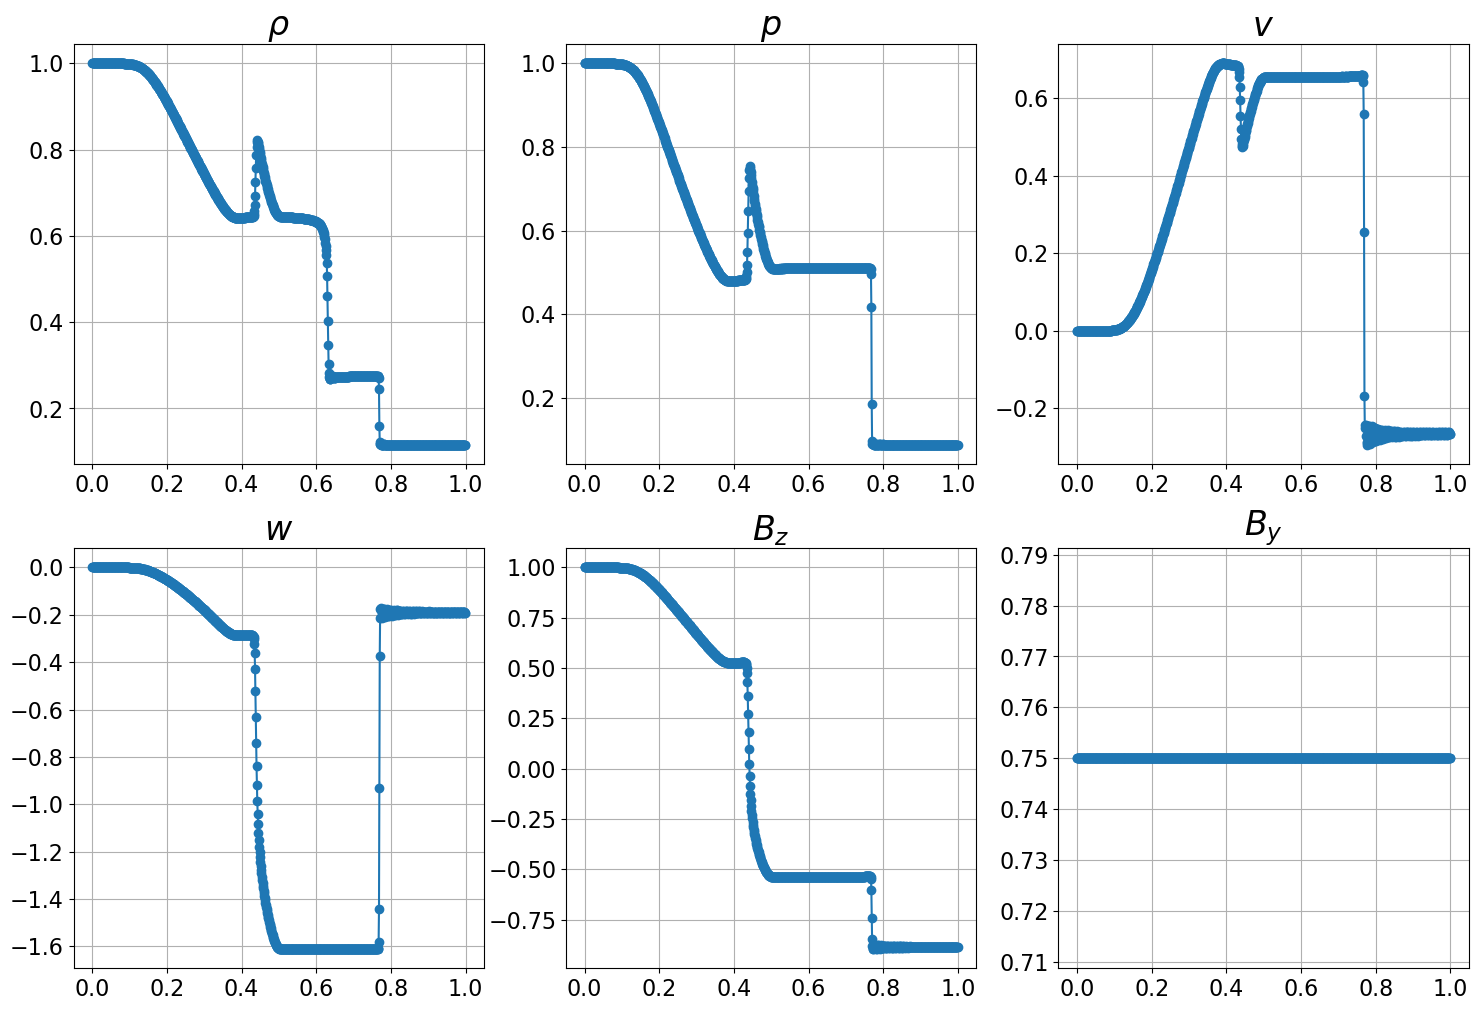

In [11]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(z, rho, marker='o')
ax2.plot(z, p, marker='o')
ax3.plot(z, w, marker='o')
ax4.plot(z, u, marker='o')
ax5.plot(z, Bx, marker='o')
ax6.plot(z, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$v$", fontsize=24)
ax4.set_title(r"$w$", fontsize=24)
ax5.set_title(r"$B_z$", fontsize=24)
ax6.set_title(r"$B_y$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

他のパラメータによるテスト \
https://ui.adsabs.harvard.edu/abs/1995ApJ...442..228R/abstract

test 1a

1840 steps (t = 0.080) : Calculation is stopped


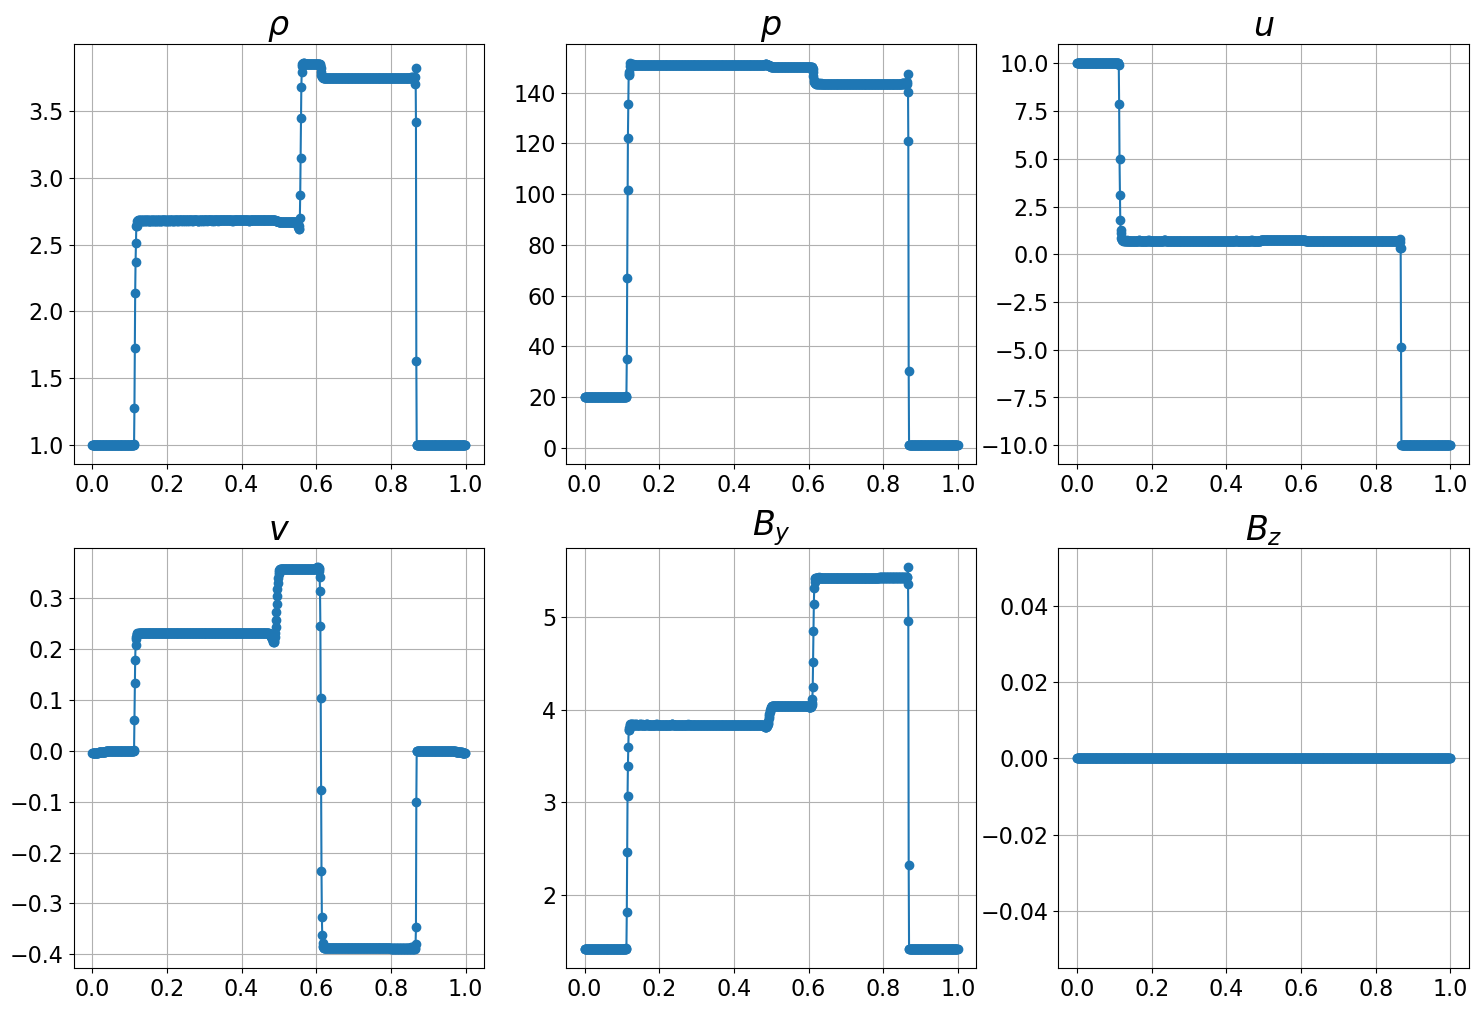

In [12]:
dx = 0.001
dt = 0.0
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 1.0
velocity_L_init = np.array([10, 0.0, 0.0])
velocity_R_init = np.array([-10, 0.0, 0.0])
B_L_init = np.array([5.0/np.sqrt(4*np.pi), 5.0/np.sqrt(4*np.pi), 0.0])
B_R_init = np.array([5.0/np.sqrt(4*np.pi), 5.0/np.sqrt(4*np.pi), 0.0])
p_L_init = 20.0
p_R_init = 1.0
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * np.linalg.norm(velocity_L_init)**2/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 10000
time = 0.0
calculation_time = 0.08
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    if np.isnan(dt):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed")
        break
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break

fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

test 1b

630 steps (t = 0.030) : Calculation is stopped


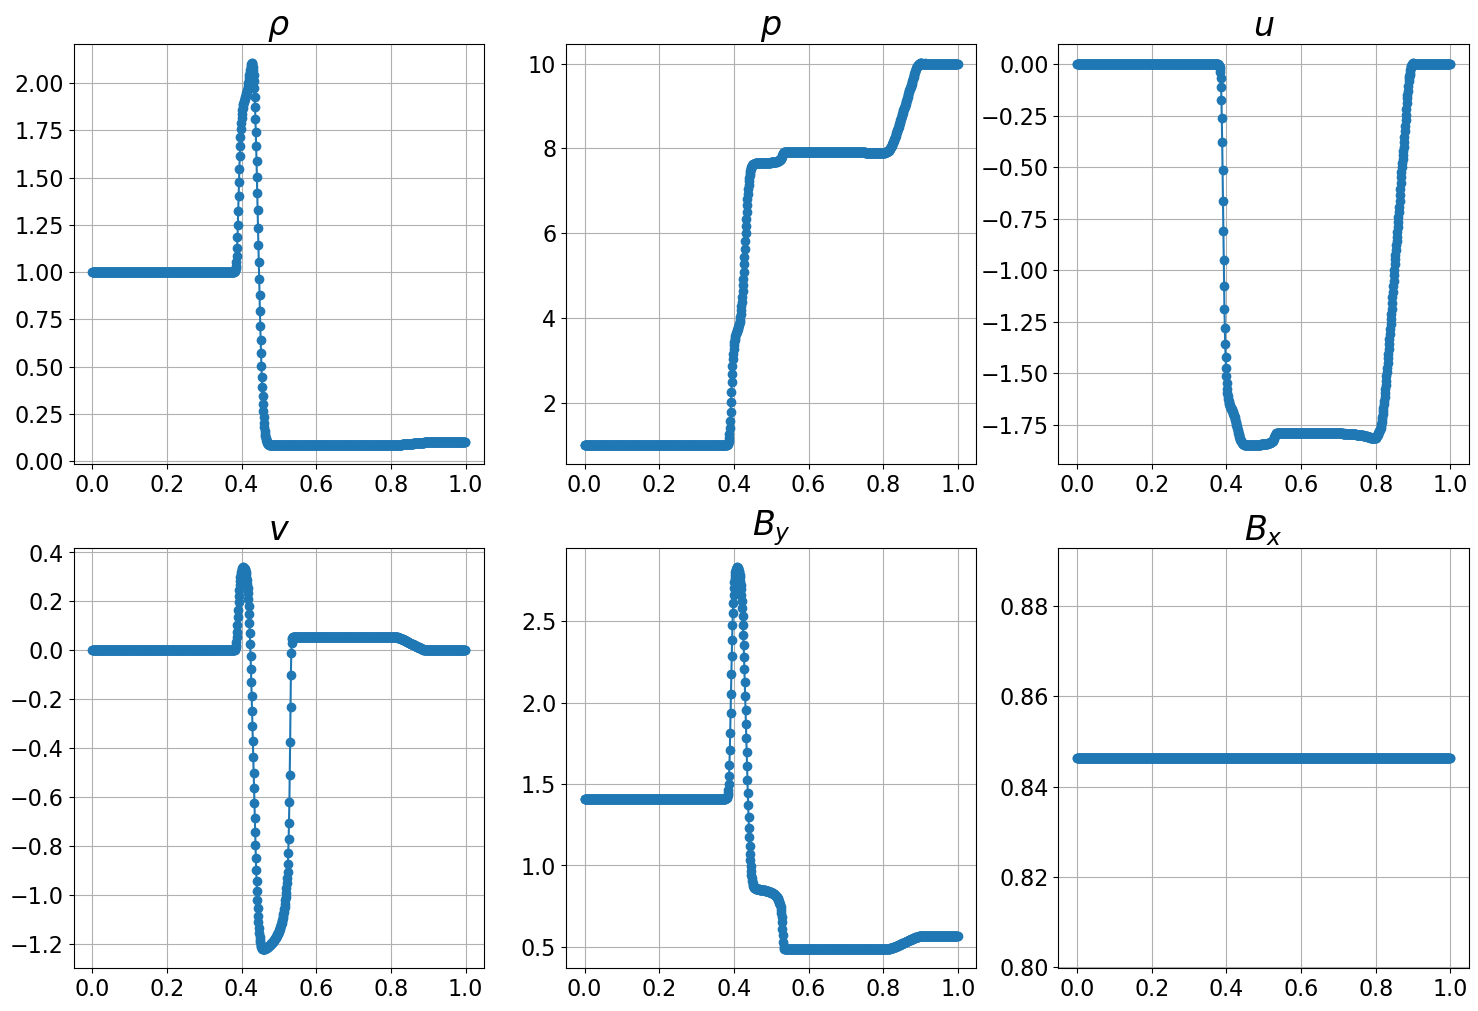

In [13]:
dx = 0.001
dt = 0.0001
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.1
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([3.0/np.sqrt(4*np.pi), 5.0/np.sqrt(4*np.pi), 0.0])
B_R_init = np.array([3.0/np.sqrt(4*np.pi), 2.0/np.sqrt(4*np.pi), 0.0])
p_L_init = 1.0
p_R_init = 10.0
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * np.linalg.norm(velocity_L_init)**2/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 10000
time = 0.0
calculation_time = 0.03
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bx, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_x$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

test 2a

839 steps (t = 0.200) : Calculation is stopped


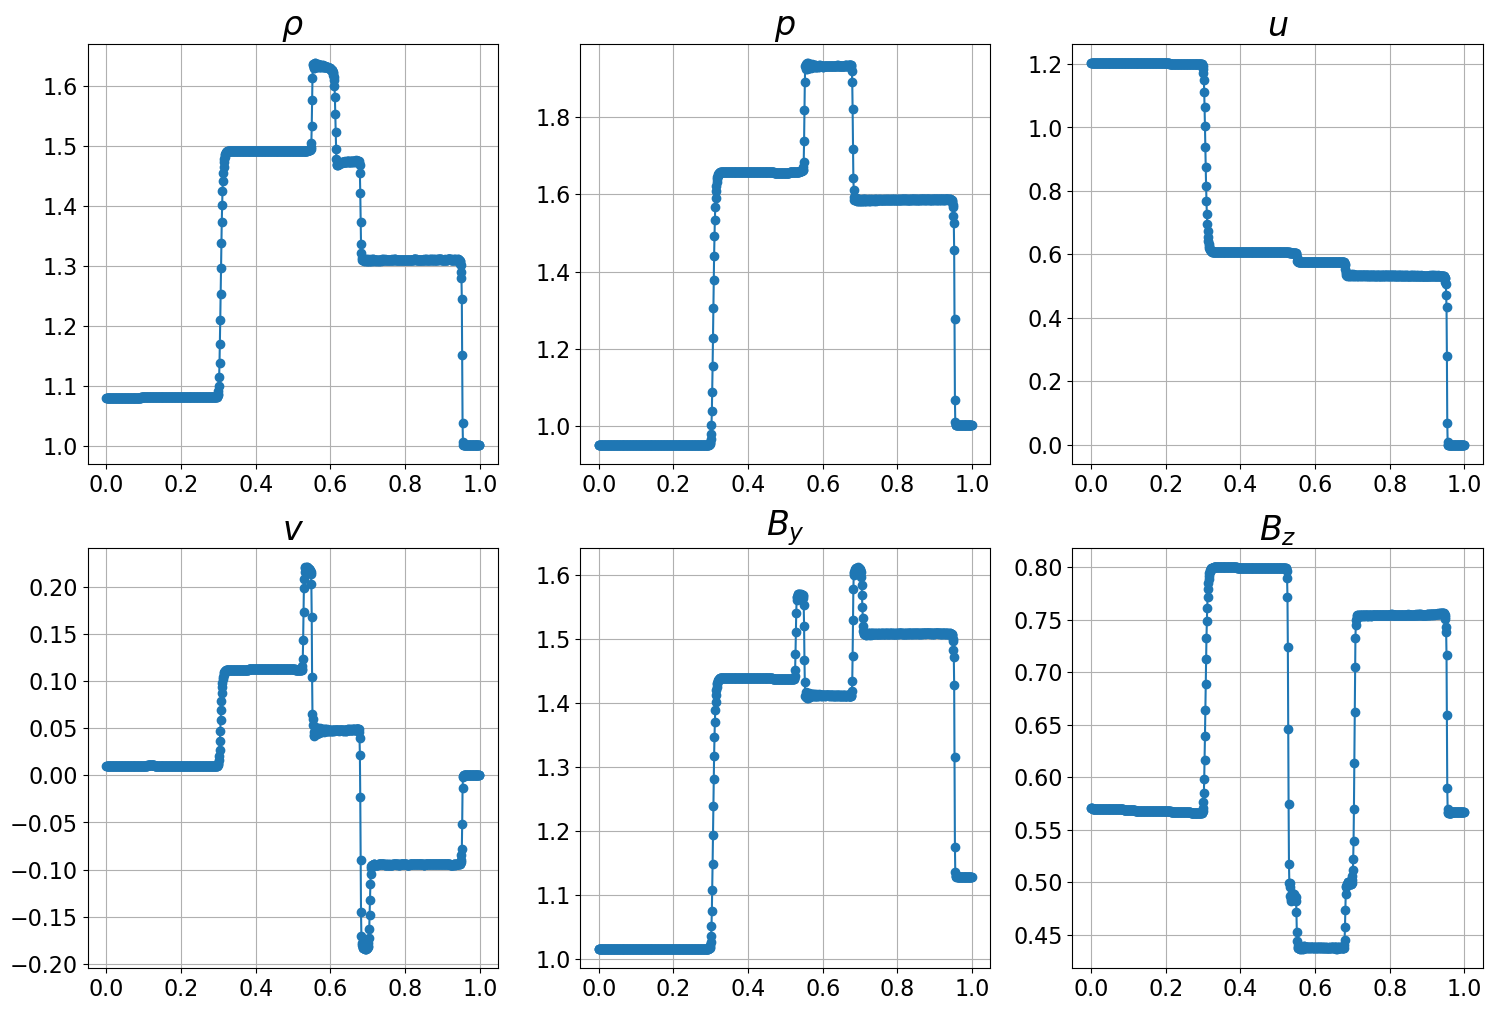

In [14]:
dx = 0.001
dt = 0.0002
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.08
rho_R_init = 1.0
velocity_L_init = np.array([1.2, 0.01, 0.5])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([2.0/np.sqrt(4*np.pi), 3.6/np.sqrt(4*np.pi), 2.0/np.sqrt(4*np.pi)])
B_R_init = np.array([2.0/np.sqrt(4*np.pi), 4.0/np.sqrt(4*np.pi), 2.0/np.sqrt(4*np.pi)])
p_L_init = 0.95
p_R_init = 1.0
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * np.linalg.norm(velocity_L_init)**2/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 10000
time = 0.0
calculation_time = 0.2
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

test 2b

743 steps (t = 0.035) : Calculation is stopped


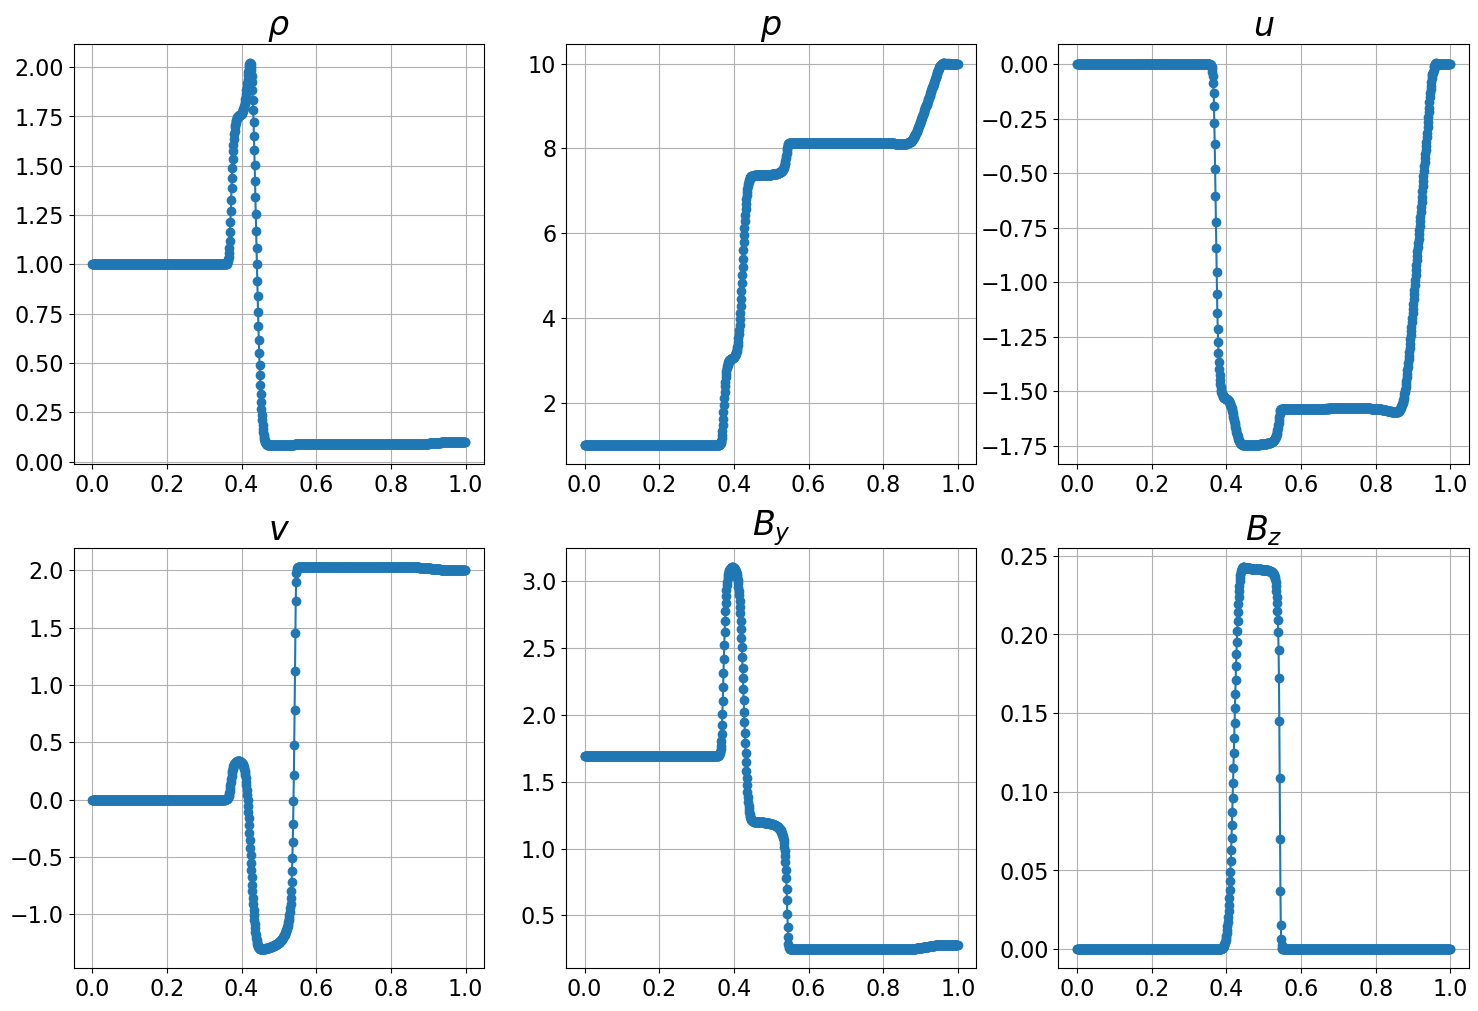

In [15]:
dx = 0.001
dt = 0.0002
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.1
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 2.0, 1.0])
B_L_init = np.array([3.0/np.sqrt(4*np.pi), 6.0/np.sqrt(4*np.pi), 0.0])
B_R_init = np.array([3.0/np.sqrt(4*np.pi), 1.0/np.sqrt(4*np.pi), 0.0])
p_L_init = 1.0
p_R_init = 10.0
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * np.linalg.norm(velocity_L_init)**2/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 10000
time = 0.0
calculation_time = 0.035
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

test 3a

785 steps (t = 0.010) : Calculation is stopped


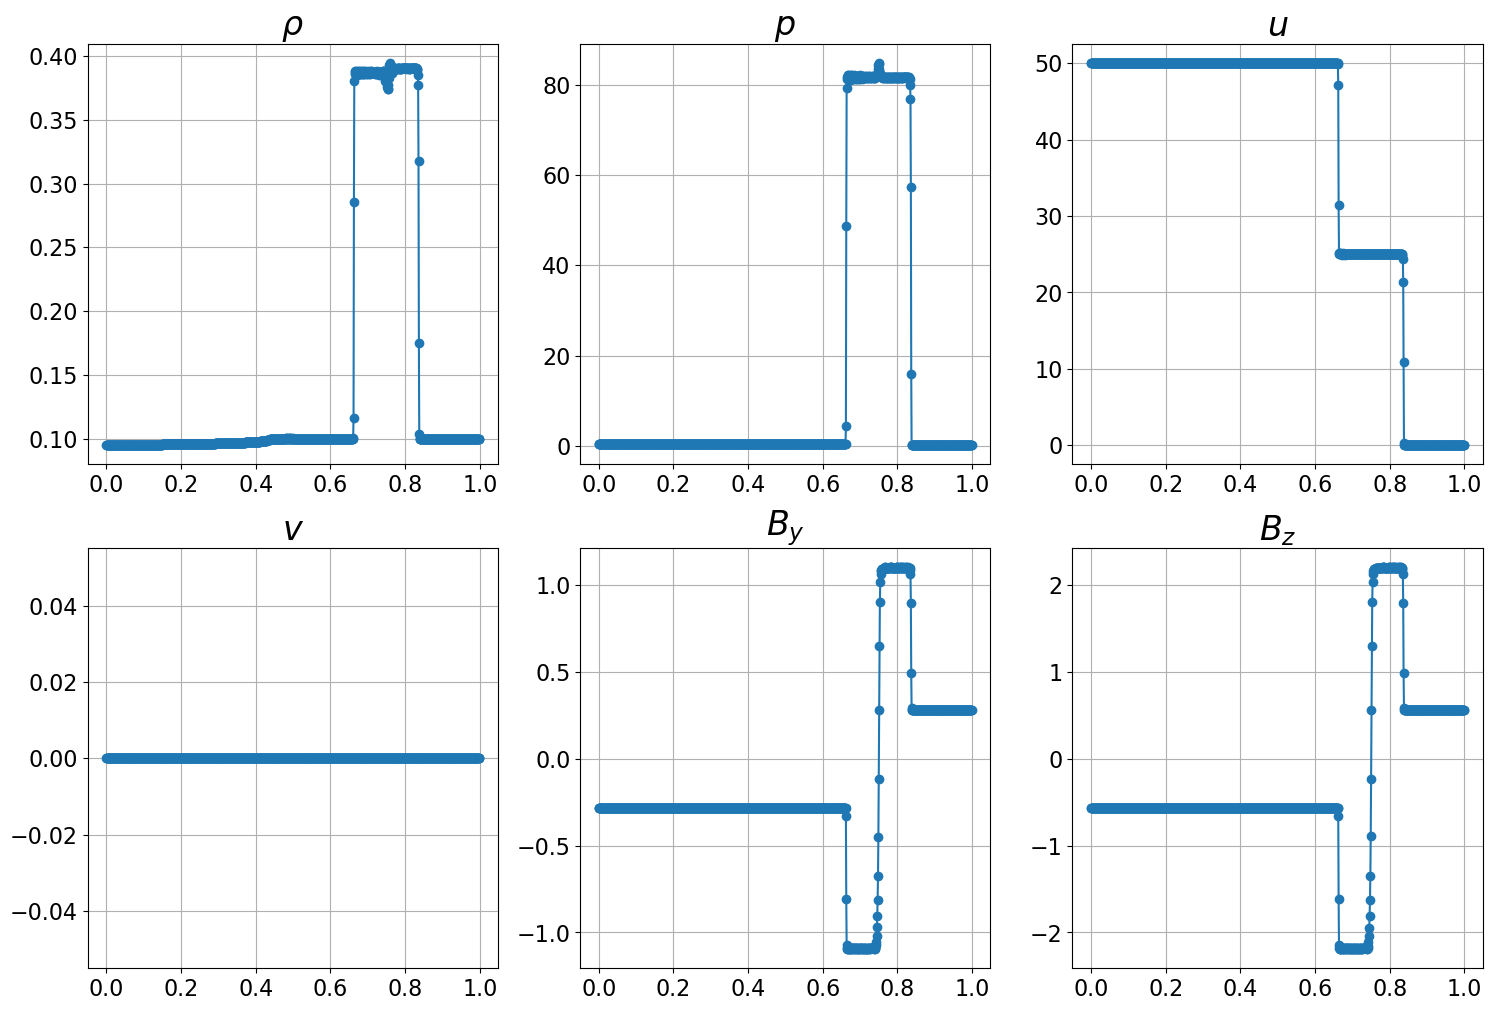

In [16]:
dx = 0.001
dt = 0.0
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 0.1
rho_R_init = 0.1
velocity_L_init = np.array([50.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([0.0, -1.0/np.sqrt(4*np.pi), -2.0/np.sqrt(4*np.pi)])
B_R_init = np.array([0.0, 1.0/np.sqrt(4*np.pi), 2.0/np.sqrt(4*np.pi)])
p_L_init = 0.4
p_R_init = 0.2
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * (np.linalg.norm(velocity_L_init)**2)/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 10000
time = 0.0
calculation_time = 0.01
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    if np.isnan(dt):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed")
        break
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

test 3b

376 steps (t = 0.100) : Calculation is stopped


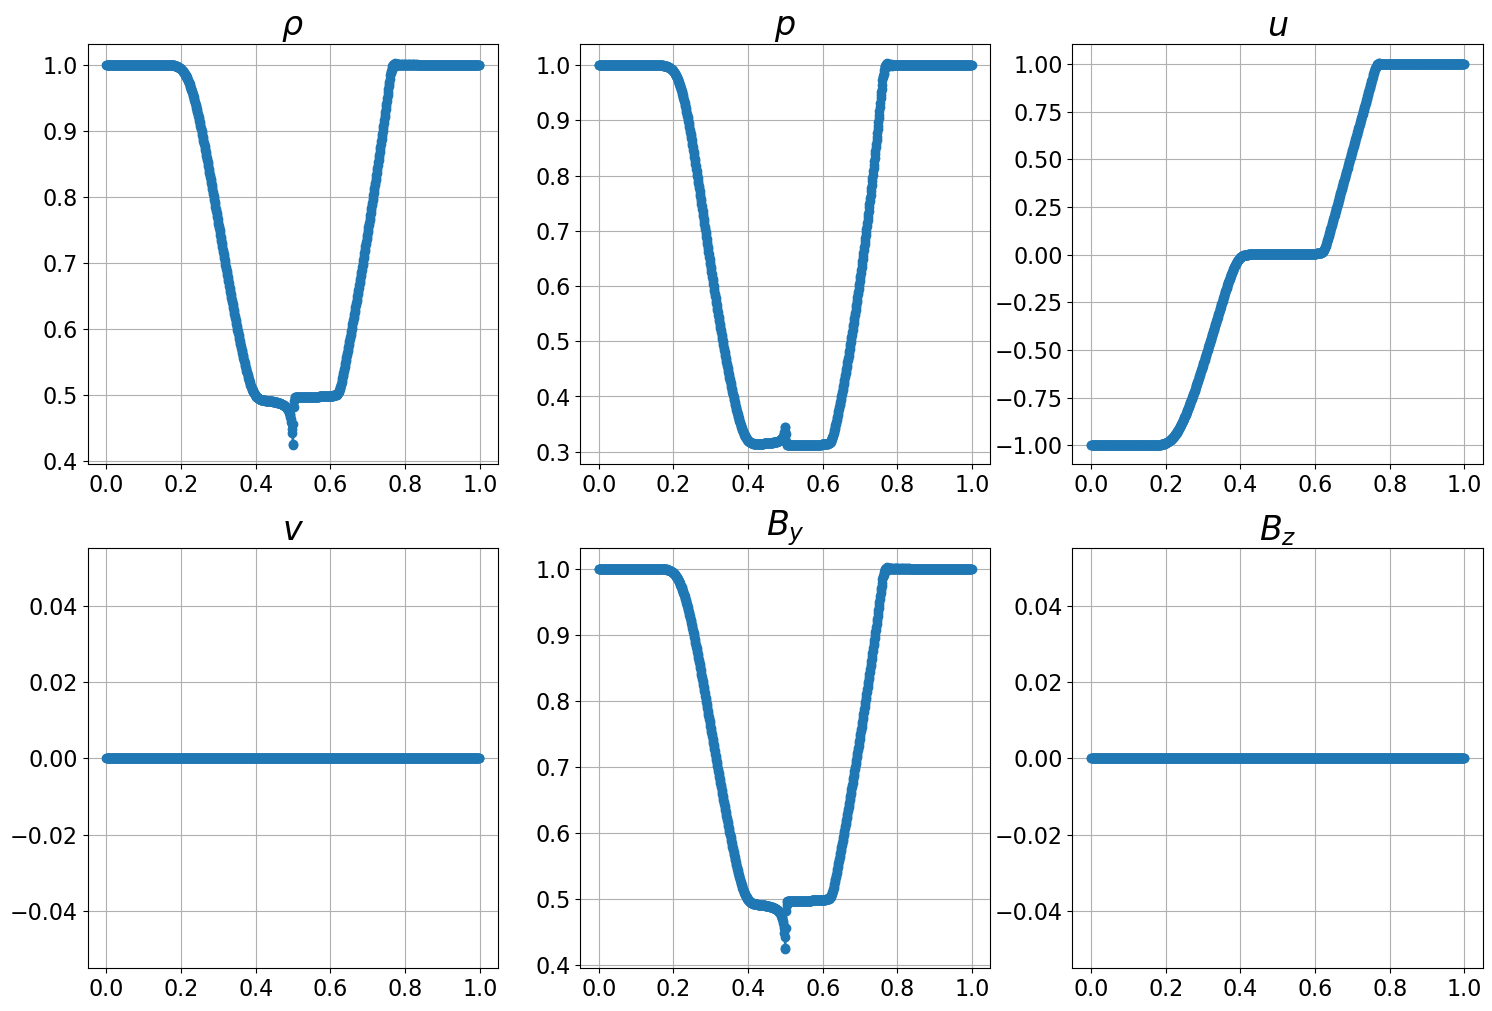

In [17]:
dx = 0.001
dt = 0.0
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 1.0
velocity_L_init = np.array([-1.0, 0.0, 0.0])
velocity_R_init = np.array([1.0, 0.0, 0.0])
B_L_init = np.array([0.0, 1.0, 0.0])
B_R_init = np.array([0.0, 1.0, 0.0])
p_L_init = 1.0
p_R_init = 1.0
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * (np.linalg.norm(velocity_L_init)**2)/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 10000
time = 0.0
calculation_time = 0.1
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    if np.isnan(dt):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed")
        break
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

test 4a

C:\Users\keita\AppData\Local\Temp\ipykernel_2360\3430427154.py:91: RuntimeWarning: invalid value encountered in sqrt
  cs_L = np.sqrt(gamma * p_L / rho_L)
C:\Users\keita\AppData\Local\Temp\ipykernel_2360\3430427154.py:92: RuntimeWarning: invalid value encountered in sqrt
  cs_R = np.sqrt(gamma * p_R / rho_R)


145 steps (t = 0.023) : Calculation is crashed


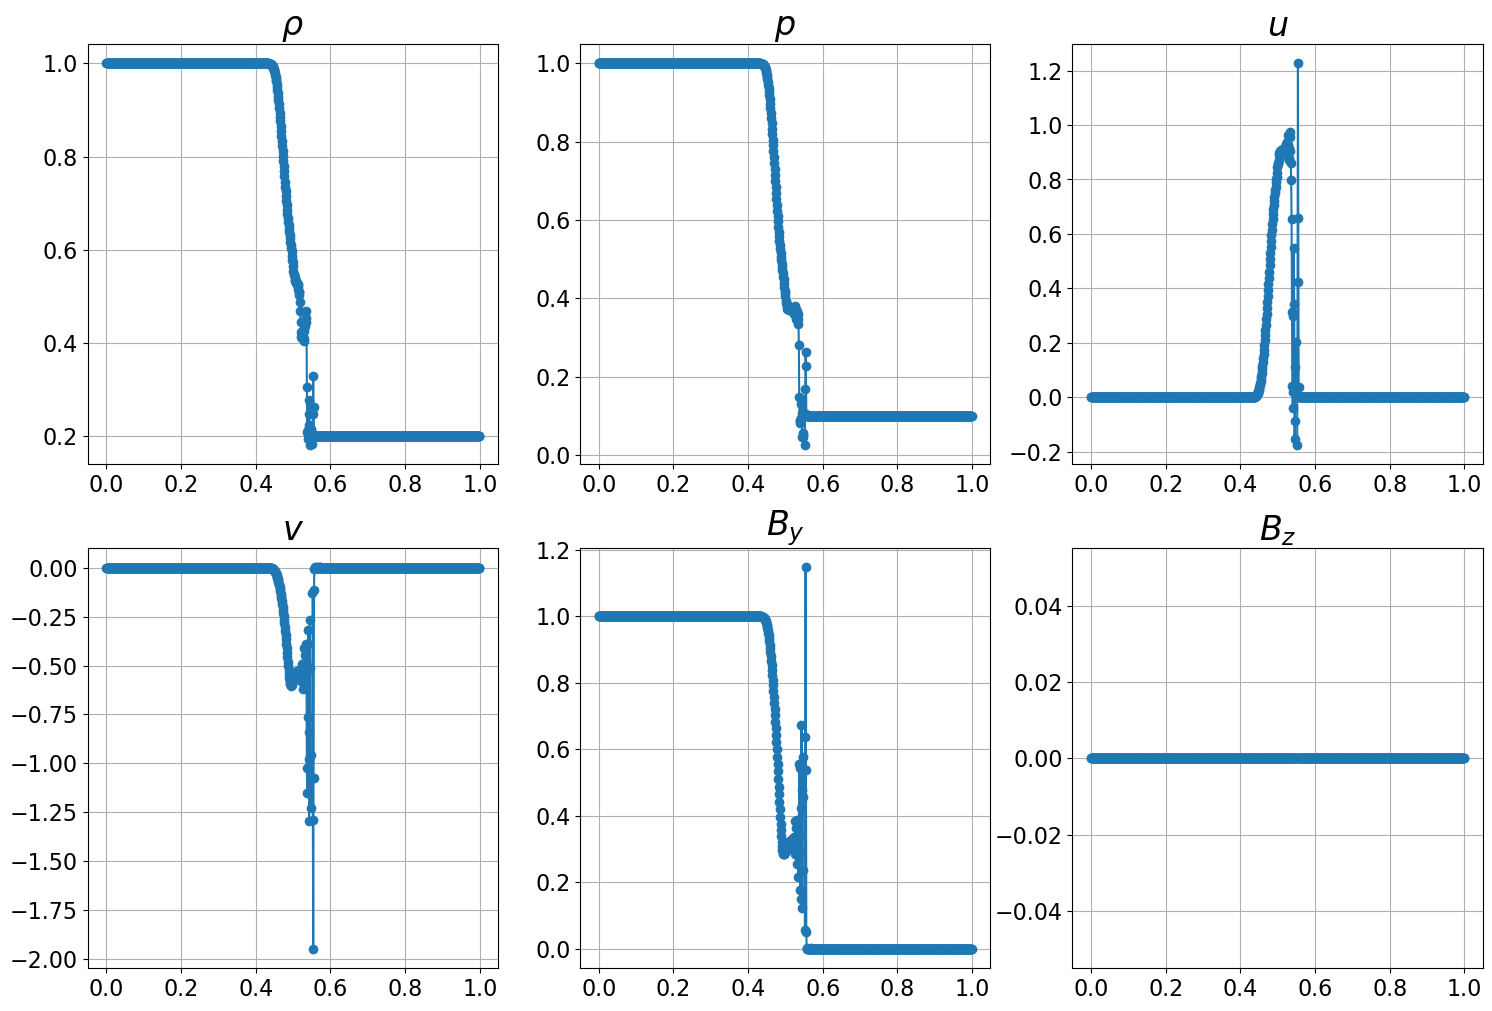

In [18]:
dx = 0.001
dt = 0.0
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.5

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.2
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([1.0, 1.0, 0.0])
B_R_init = np.array([1.0, 0.0, 0.0])
p_L_init = 1.0
p_R_init = 0.1
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * (np.linalg.norm(velocity_L_init)**2)/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 100000
time = 0.0
calculation_time = 0.15
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    if np.isnan(dt):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed")
        break
    
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

test 4b

686 steps (t = 0.150) : Calculation is stopped


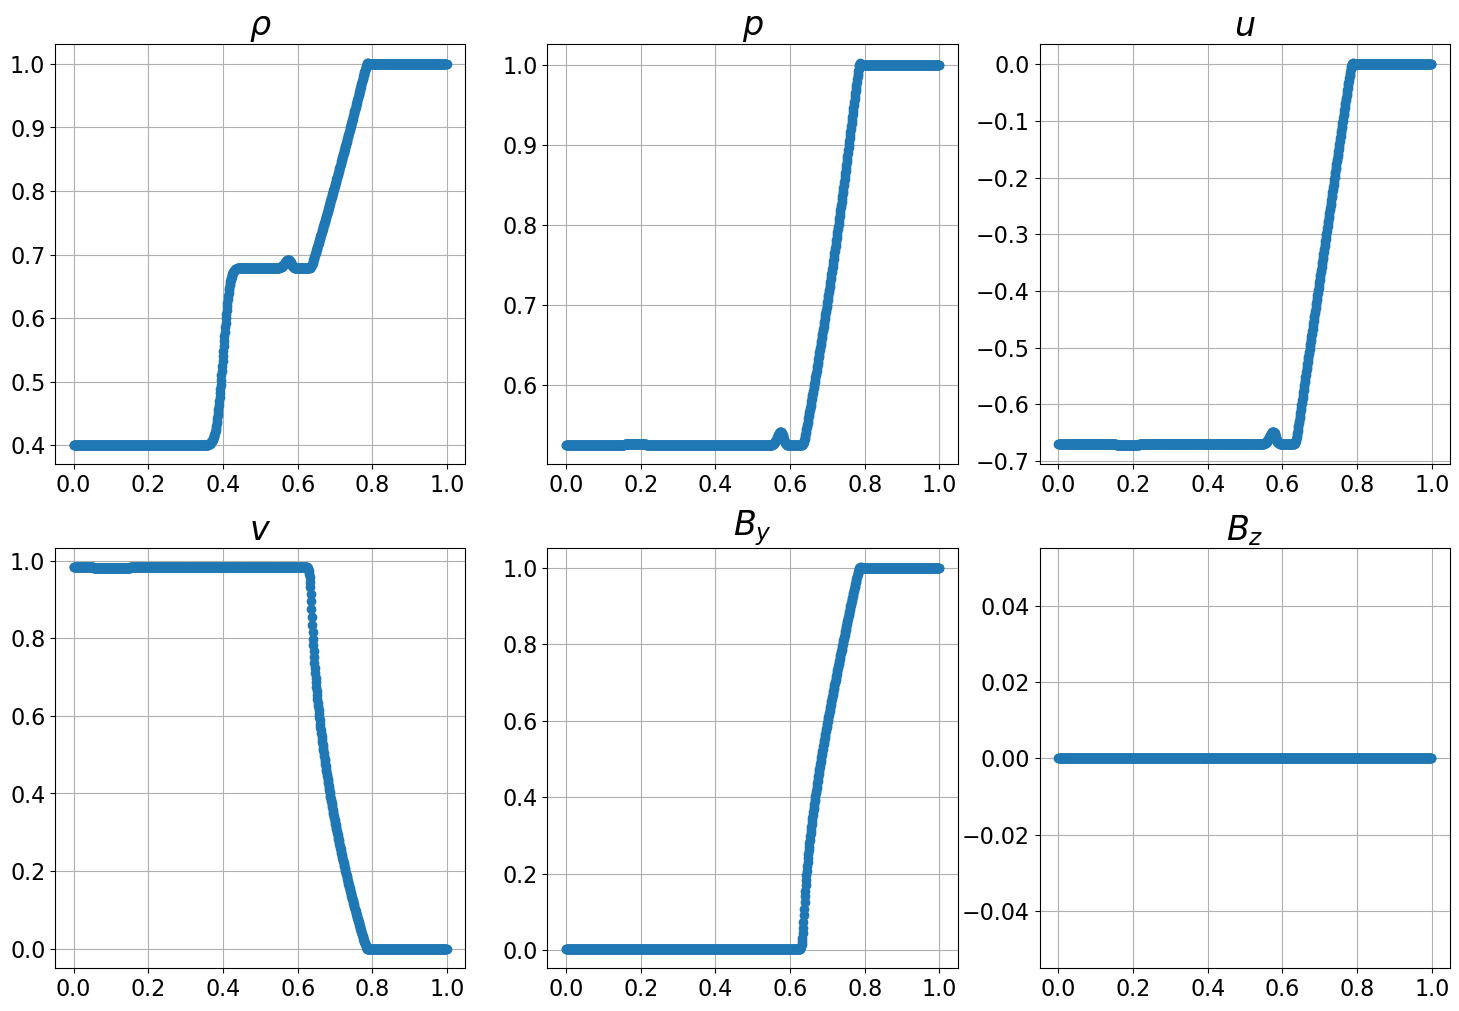

In [19]:
dx = 0.001
dt = 0.0
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 0.4
rho_R_init = 1.0
velocity_L_init = np.array([-0.66991, 0.98263, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([1.3, 0.0025293, 0.0])
B_R_init = np.array([1.3, 1.0, 0.0])
p_L_init = 0.52467
p_R_init = 1.0
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * (np.linalg.norm(velocity_L_init)**2)/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 10000
time = 0.0
calculation_time = 0.15
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    if np.isnan(dt):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed")
        break
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

test 4c

489 steps (t = 0.150) : Calculation is stopped


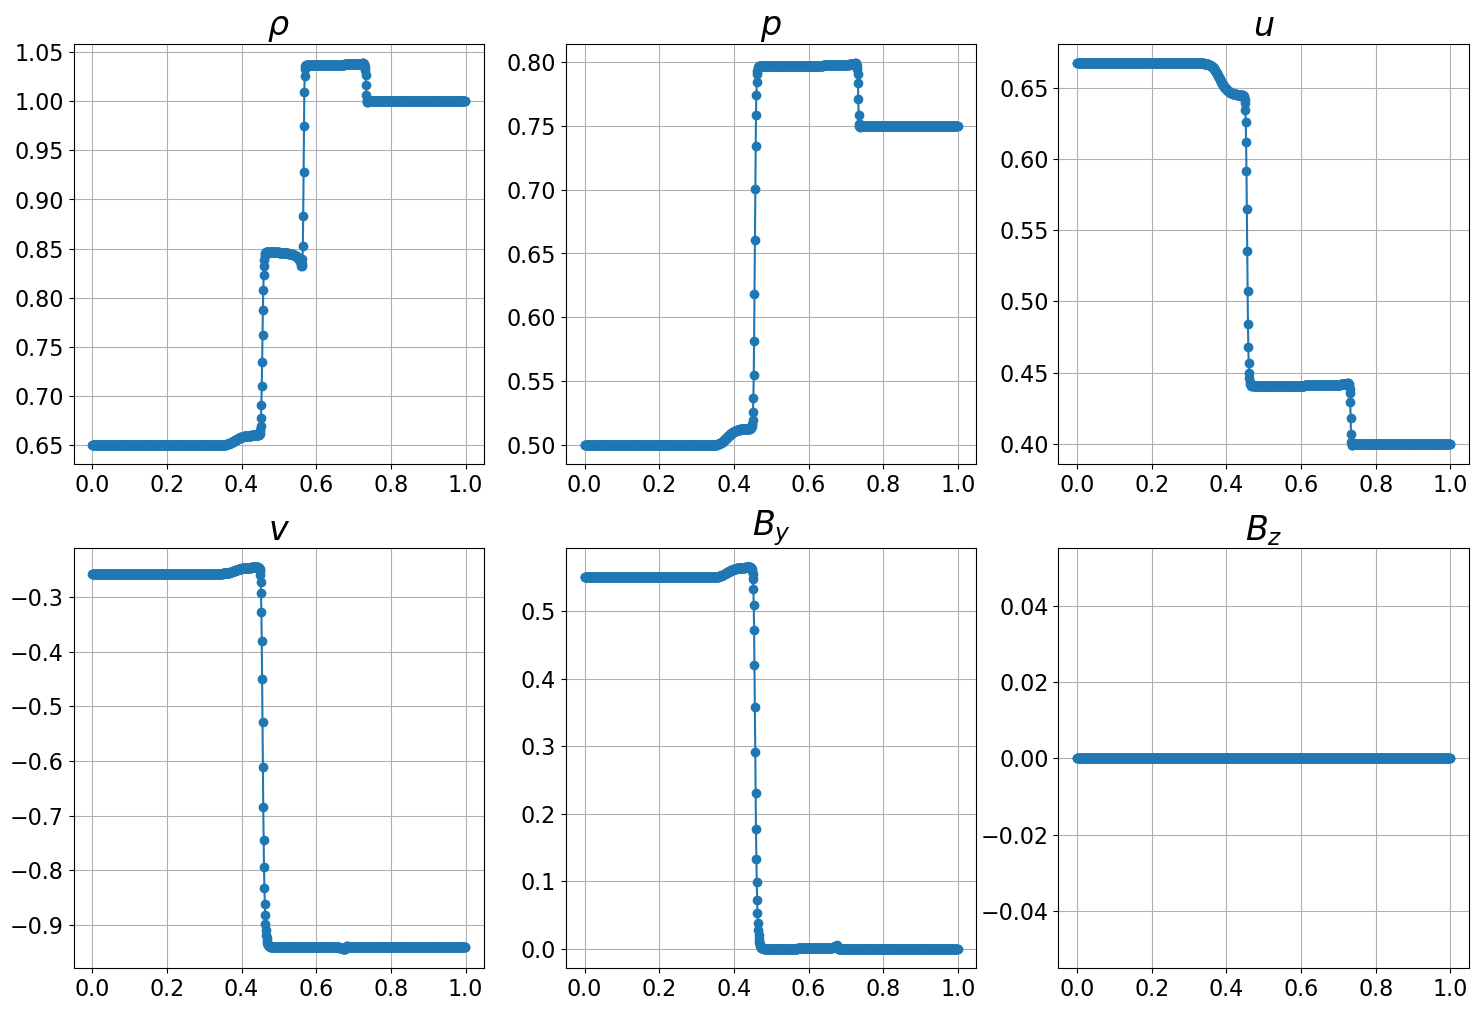

In [20]:
dx = 0.001
dt = 0.0
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 0.65
rho_R_init = 1.0
velocity_L_init = np.array([0.667, -0.257, 0.0])
velocity_R_init = np.array([0.4, -0.94, 0.0])
B_L_init = np.array([0.75, 0.55, 0.0])
B_R_init = np.array([0.75, 0.0, 0.0])
p_L_init = 0.5
p_R_init = 0.75
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * (np.linalg.norm(velocity_L_init)**2)/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 10000
time = 0.0
calculation_time = 0.15
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    if np.isnan(dt):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed")
        break
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

test 4d

567 steps (t = 0.160) : Calculation is stopped


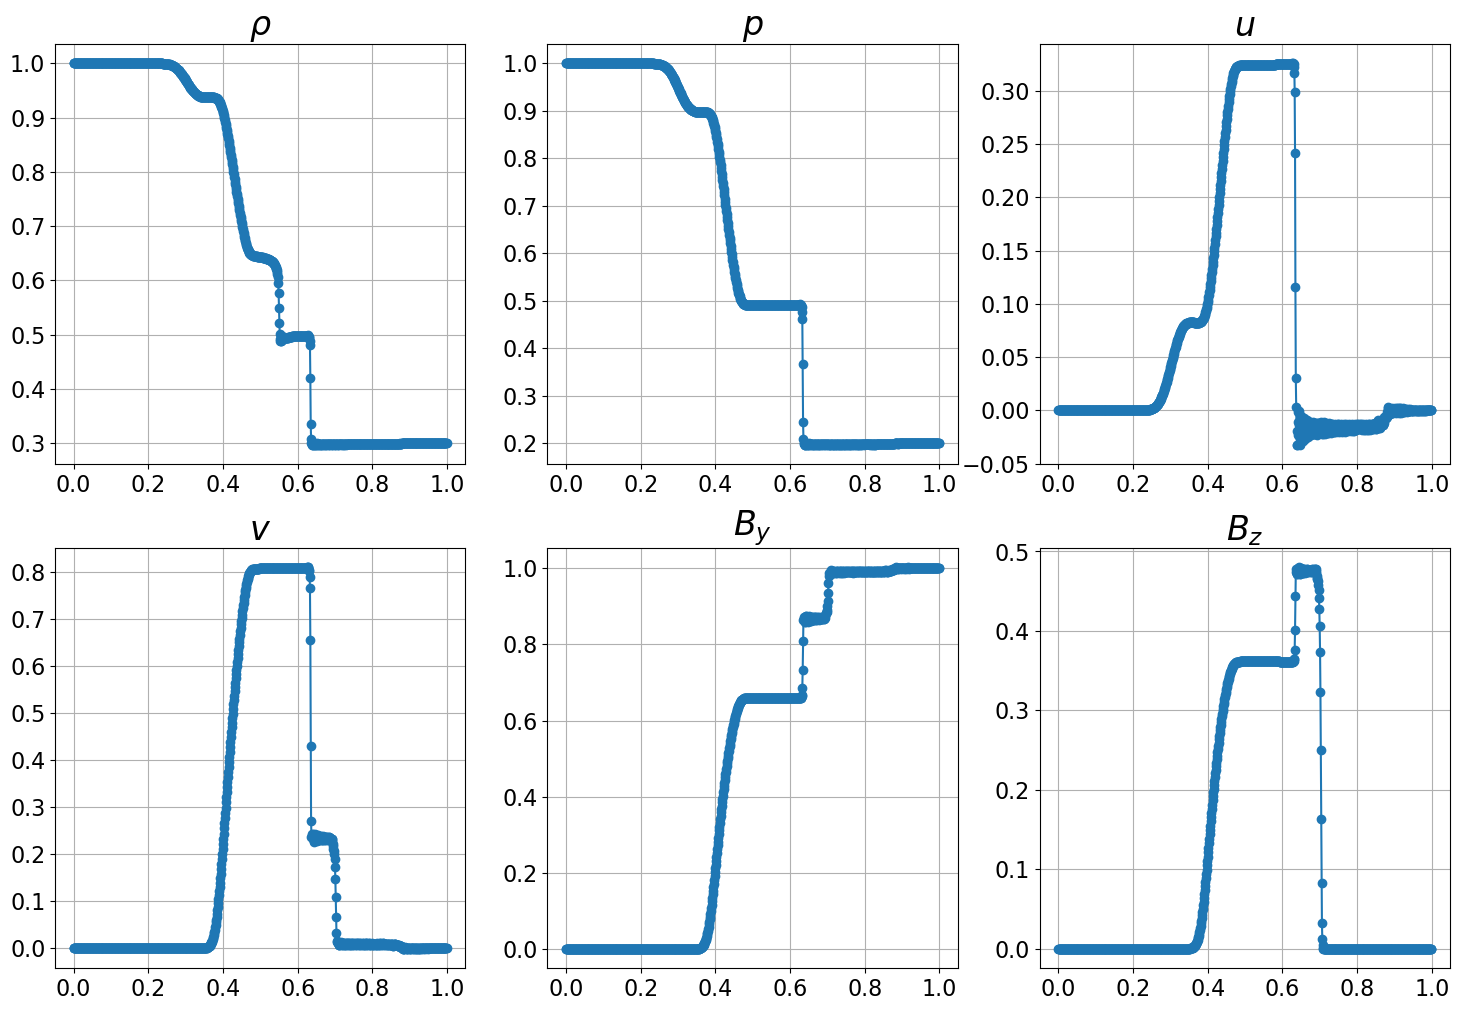

In [21]:
dx = 0.001
dt = 0.0
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.3
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 1.0])
B_L_init = np.array([0.7, 0.0, 0.0])
B_R_init = np.array([0.7, 1.0, 0.0])
p_L_init = 1.0
p_R_init = 0.2
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * (np.linalg.norm(velocity_L_init)**2)/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 10000
time = 0.0
calculation_time = 0.16
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    if np.isnan(dt):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed")
        break
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

test 5a

553 steps (t = 0.100) : Calculation is stopped


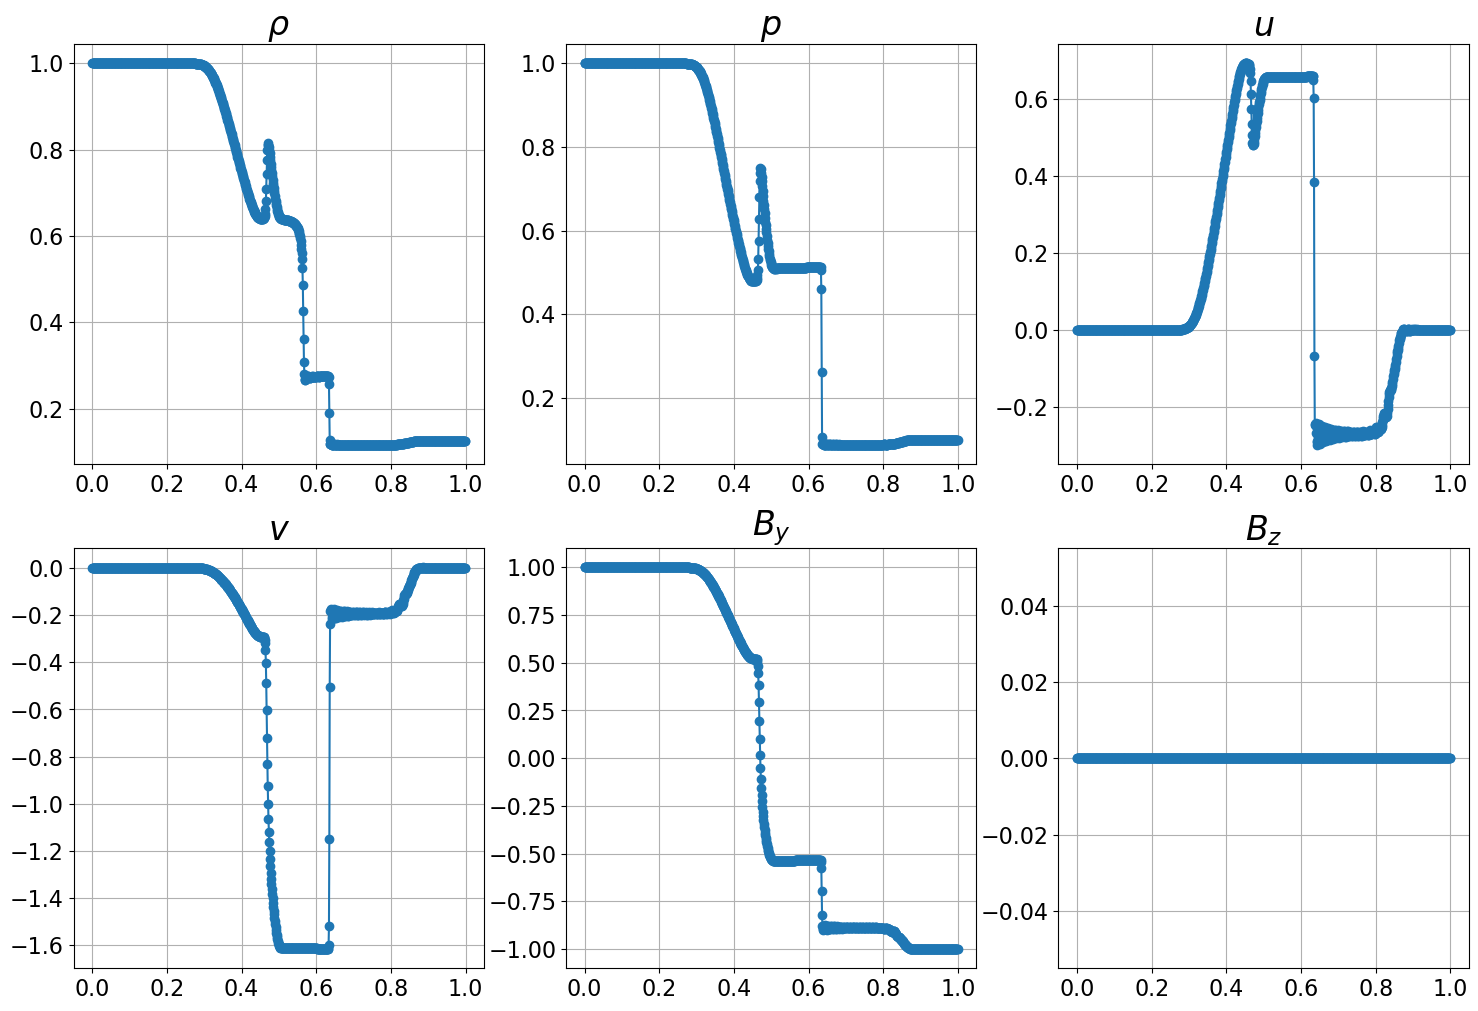

In [22]:
dx = 0.001
dt = 0.0
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.125
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([0.75, 1.0, 0.0])
B_R_init = np.array([0.75, -1.0, 0.0])
p_L_init = 1.0
p_R_init = 0.1
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * (np.linalg.norm(velocity_L_init)**2)/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 10000
time = 0.0
calculation_time = 0.1
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    if np.isnan(dt):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed")
        break
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()

test 5b

742 steps (t = 0.160) : Calculation is stopped


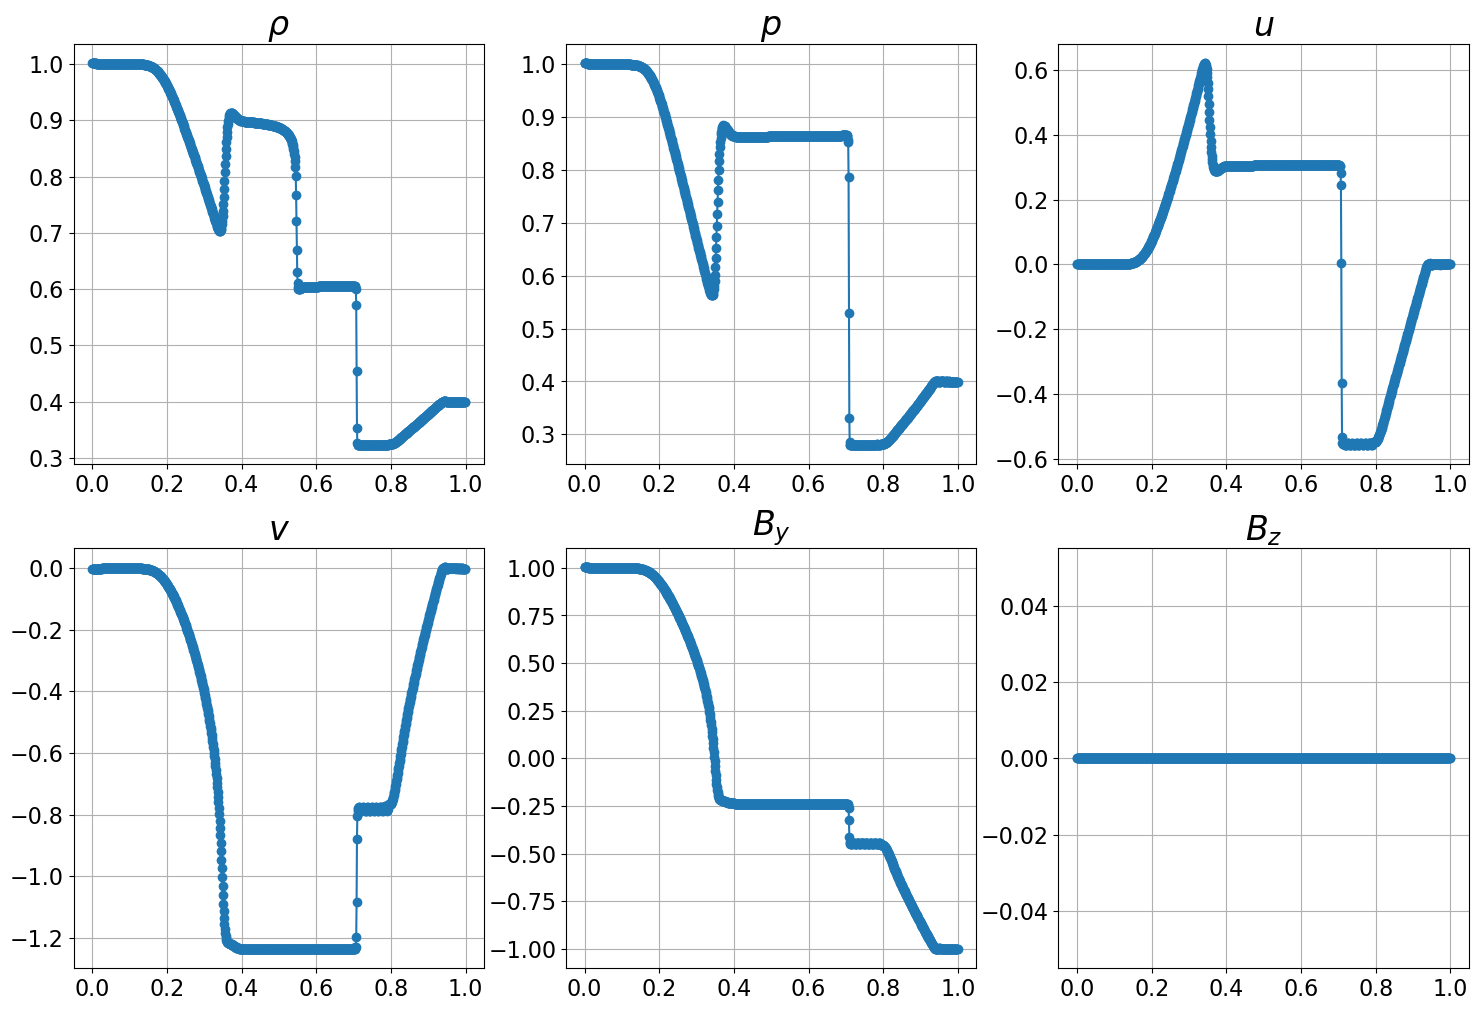

In [23]:
dx = 0.001
dt = 0.0
x_max = 1.0
x = np.arange(0.0, x_max, dx)
nmax = len(x)
CFL = 0.7

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_L_init = 1.0
rho_R_init = 0.4
velocity_L_init = np.array([0.0, 0.0, 0.0])
velocity_R_init = np.array([0.0, 0.0, 0.0])
B_L_init = np.array([1.3, 1.0, 0.0])
B_R_init = np.array([1.3, -1.0, 0.0])
p_L_init = 1.0
p_R_init = 0.4
U[0, x < x_max/2] = rho_L_init
U[0, x >= x_max/2] = rho_R_init
U[1, x < x_max/2] = rho_L_init * velocity_L_init[0]
U[1, x >= x_max/2] = rho_R_init * velocity_R_init[0]
U[2, x < x_max/2] = rho_L_init * velocity_L_init[1]
U[2, x >= x_max/2] = rho_R_init * velocity_R_init[1]
U[3, x < x_max/2] = rho_L_init * velocity_L_init[2]
U[3, x >= x_max/2] = rho_R_init * velocity_R_init[2]
U[4, x < x_max/2] = B_L_init[0]
U[4, x >= x_max/2] = B_R_init[0]
U[5, x < x_max/2] = B_L_init[1]
U[5, x >= x_max/2] = B_R_init[1]
U[6, x < x_max/2] = B_L_init[2]
U[6, x >= x_max/2] = B_R_init[2]
U[7, x < x_max/2] = p_L_init/(gamma-1) + rho_L_init * (np.linalg.norm(velocity_L_init)**2)/2 + np.linalg.norm(B_L_init)**2/2
U[7, x >= x_max/2] = p_R_init/(gamma-1) + rho_R_init * np.linalg.norm(velocity_R_init)**2/2 + np.linalg.norm(B_R_init)**2/2
U_bar = U.copy()

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)

max_step = 10000
time = 0.0
calculation_time = 0.16
for t in range(max_step+1):
    U_bar = U.copy()

    rho = U[0, :]
    u = U[1, :] / rho
    v = U[2, :] / rho
    w = U[3, :] / rho
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    
    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx))
    if np.isnan(dt):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed")
        break
    
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U_bar[:, 0] = U_bar[:, 1]
    U_bar[:, -1] = U_bar[:, -2]

    rho = U_bar[0, :]
    u = U_bar[1, :] / rho
    v = U_bar[2, :] / rho
    w = U_bar[3, :] / rho
    Bx = U_bar[4, :]
    By = U_bar[5, :]
    Bz = U_bar[6, :]
    e = U_bar[7, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    F = 1/2 * (F + F_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1))
    # 対称境界条件
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break


fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x, rho, marker='o')
ax2.plot(x, p, marker='o')
ax3.plot(x, u, marker='o')
ax4.plot(x, v, marker='o')
ax5.plot(x, By, marker='o')
ax6.plot(x, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.show()